In [0]:
# Step 1: Initialize Spark session and load data

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("HR Employee Churn").getOrCreate()

# Define file location and type
file_location = "/FileStore/tables/hr_employee_churn_data.csv"
file_type = "csv"

# Load the data into a Spark DataFrame
df_spark = spark.read.format(file_type) \
  .option("inferSchema", "true") \
  .option("header", "true") \
  .option("sep", ",") \
  .load(file_location)

# Show the first few rows of the DataFrame
df_spark.show()


+-----+------------------+---------------+--------------+--------------------+------------------+-------------+---------------------+------+----+
|empid|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|promotion_last_5years|salary|left|
+-----+------------------+---------------+--------------+--------------------+------------------+-------------+---------------------+------+----+
|    1|              0.38|           0.53|             2|                 157|                 3|            0|                    0|   low|   1|
|    2|               0.8|           0.86|             5|                 262|                 6|            0|                    0|medium|   1|
|    3|              0.11|           0.88|             7|                 272|                 4|            0|                    0|medium|   1|
|    4|              0.72|           0.87|             5|                 223|                 5|            0|             

In [0]:
# Step 2: Initial data exploration with Spark SQL

# Create a temporary view
df_spark.createOrReplaceTempView("hr_employee_churn")

# Use Spark SQL to query the data
query = """
SELECT COUNT(*) AS total_records,
       AVG(satisfaction_level) AS avg_satisfaction_level,
       AVG(last_evaluation) AS avg_last_evaluation,
       AVG(number_project) AS avg_number_project,
       AVG(average_montly_hours) AS avg_monthly_hours,
       AVG(time_spend_company) AS avg_time_spent,
       SUM(CASE WHEN left = 1 THEN 1 ELSE 0 END) AS total_churn
FROM hr_employee_churn
"""

# Run the query and show the results
df_summary = spark.sql(query)
df_summary.show()


+-------------+----------------------+-------------------+------------------+-----------------+-----------------+-----------+
|total_records|avg_satisfaction_level|avg_last_evaluation|avg_number_project|avg_monthly_hours|   avg_time_spent|total_churn|
+-------------+----------------------+-------------------+------------------+-----------------+-----------------+-----------+
|        14999|    0.6128625725145042| 0.7161017401160074|  3.80305353690246|201.0503366891126|3.498233215547703|       3571|
+-------------+----------------------+-------------------+------------------+-----------------+-----------------+-----------+



In [0]:
# Step 3: Data preprocessing with PySpark

from pyspark.sql.functions import mean, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Handle missing values
mean_satisfaction_level = df_spark.select(mean(col('satisfaction_level'))).collect()[0][0]
df_spark = df_spark.na.fill({'satisfaction_level': mean_satisfaction_level})

# Encode categorical variables using StringIndexer and OneHotEncoder
indexer = StringIndexer(inputCol="salary", outputCol="salaryIndex")
df_spark = indexer.fit(df_spark).transform(df_spark)

encoder = OneHotEncoder(inputCols=["salaryIndex"], outputCols=["salaryVec"])
df_spark = encoder.fit(df_spark).transform(df_spark)

# Use VectorAssembler to combine all feature columns into a single vector column
assembler = VectorAssembler(inputCols=['satisfaction_level', 'last_evaluation', 'number_project', 
                                       'average_montly_hours', 'time_spend_company', 'Work_accident', 
                                       'promotion_last_5years', 'salaryVec'], outputCol="features")
df_spark = assembler.transform(df_spark)

# Drop the intermediate columns
df_spark = df_spark.drop("salary", "salaryIndex", "salaryVec")

# Show the processed Spark DataFrame
df_spark.show()


+-----+------------------+---------------+--------------+--------------------+------------------+-------------+---------------------+----+--------------------+
|empid|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|promotion_last_5years|left|            features|
+-----+------------------+---------------+--------------+--------------------+------------------+-------------+---------------------+----+--------------------+
|    1|              0.38|           0.53|             2|                 157|                 3|            0|                    0|   1|[0.38,0.53,2.0,15...|
|    2|               0.8|           0.86|             5|                 262|                 6|            0|                    0|   1|[0.8,0.86,5.0,262...|
|    3|              0.11|           0.88|             7|                 272|                 4|            0|                    0|   1|[0.11,0.88,7.0,27...|
|    4|              0.72|           0.8

In [0]:
# Step 4: Convert Spark DataFrame to Pandas for further processing
import pandas as pd
import numpy as np 

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df_spark.select("empid", "features", "left").toPandas()

# Function to extract features from the vector column
def extract_features(features_vector):
    return features_vector.toArray()

# Apply the function to extract features
features_array = np.array(df_pandas['features'].apply(lambda x: x.toArray()).tolist())

# Define feature names
feature_names = ['satisfaction_level', 'last_evaluation', 'number_project', 
                 'average_montly_hours', 'time_spend_company', 'Work_accident', 
                 'promotion_last_5years', 'salaryVec_0', 'salaryVec_1']

# Create a DataFrame from the features array
features_df = pd.DataFrame(features_array, columns=feature_names)

# Combine the features DataFrame with the target and ID columns
df_pandas = pd.concat([df_pandas[['empid', 'left']], features_df], axis=1)

# Show the first few rows of the Pandas DataFrame
print(df_pandas.head())


   empid  left  ...  salaryVec_0  salaryVec_1
0      1     1  ...          1.0          0.0
1      2     1  ...          0.0          1.0
2      3     1  ...          0.0          1.0
3      4     1  ...          1.0          0.0
4      5     1  ...          1.0          0.0

[5 rows x 11 columns]


In [0]:
df_pandas.sample(5)

,empid,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salaryVec_0,salaryVec_1
10490,10491,0,0.50,0.70,4.0,135.0,3.0,0.0,0.0,1.0,0.0
11085,11086,0,0.57,0.67,3.0,138.0,6.0,1.0,0.0,0.0,1.0
6611,6612,0,0.98,0.53,4.0,166.0,2.0,0.0,0.0,0.0,1.0
12653,12654,1,0.37,0.51,2.0,132.0,3.0,0.0,0.0,0.0,1.0
2737,2738,0,0.63,0.50,3.0,246.0,3.0,0.0,0.0,1.0,0.0


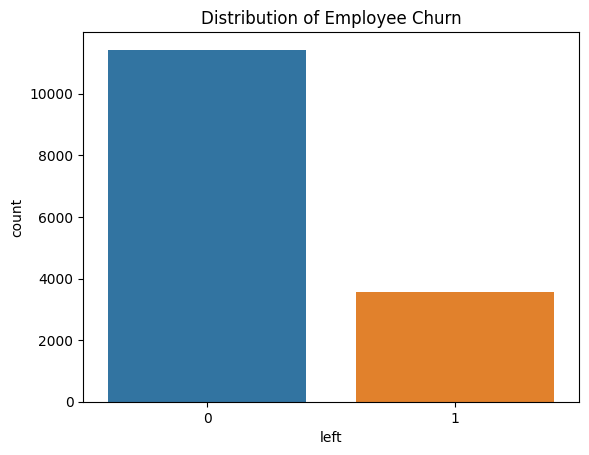

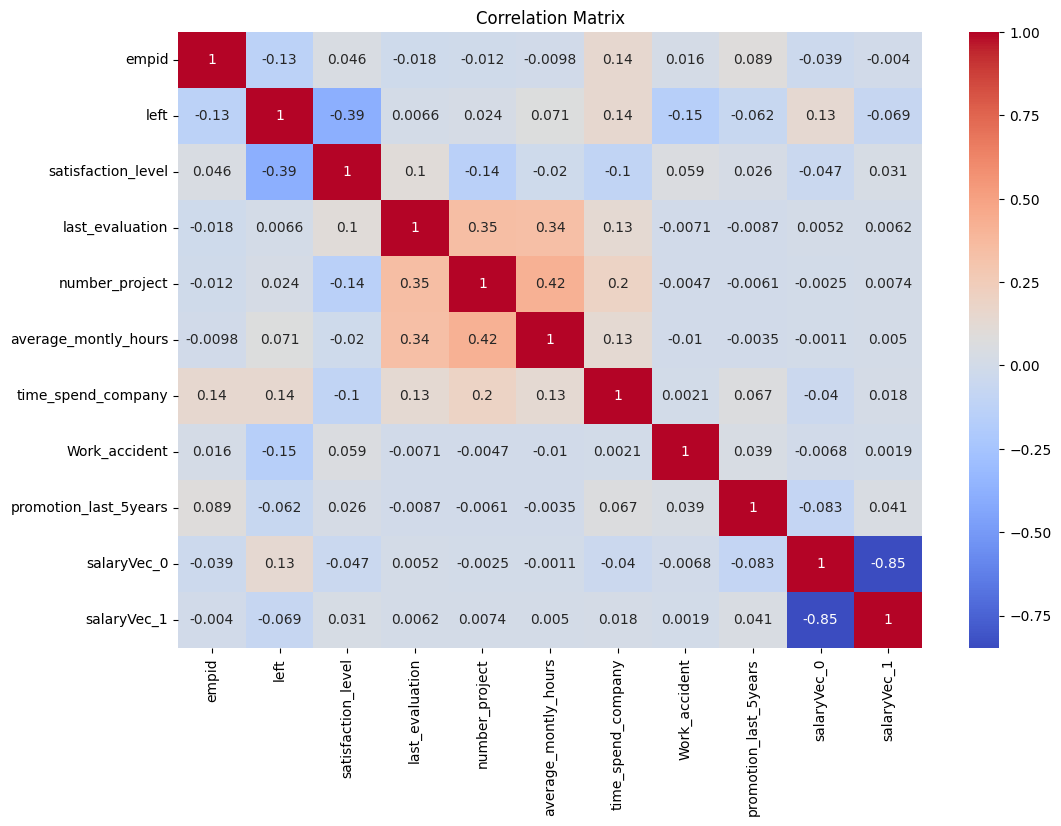

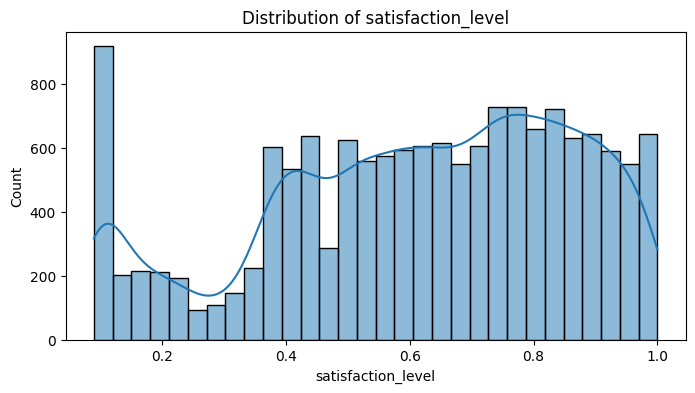

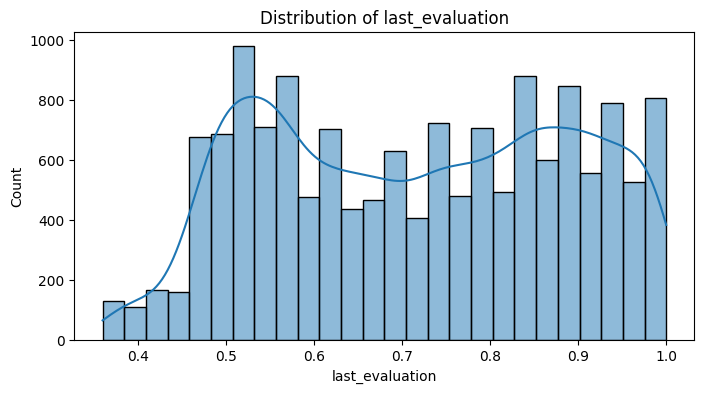

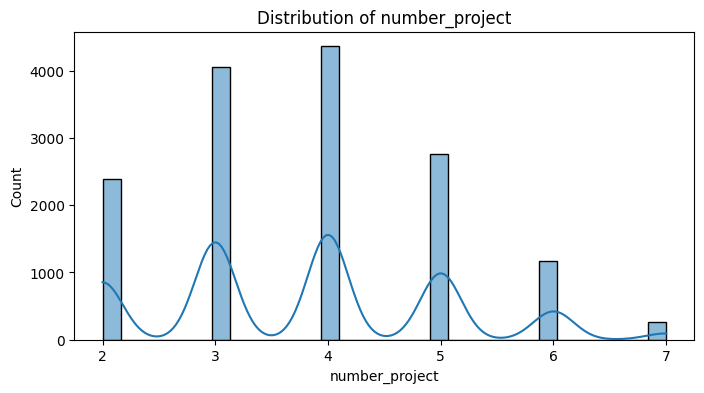

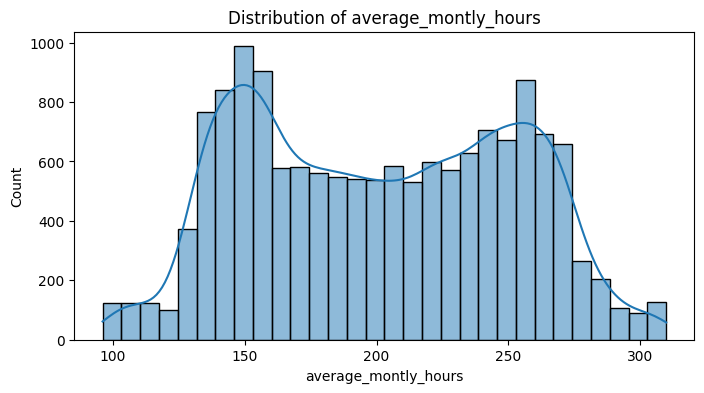

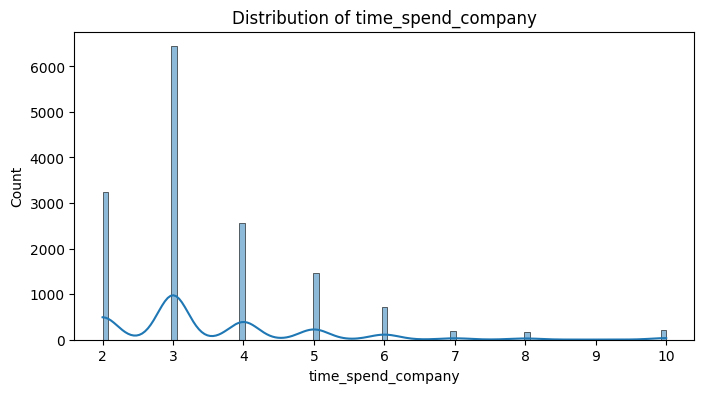

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the target variable 'left'
sns.countplot(x='left', data=df_pandas)
plt.title('Distribution of Employee Churn')
plt.show()

# Plot the correlation matrix
corr_matrix = df_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Plot distributions of numerical features
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_pandas[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [0]:
# Step 6: Machine Learning Model Building with Scikit-Learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define features and target variable
X = df_pandas.drop(columns=['empid', 'left'])
y = df_pandas['left']

In [0]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [0]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

Logistic Regression - Accuracy: 0.7767, ROC-AUC: 0.6123
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2294
           1       0.55      0.30      0.39       706

    accuracy                           0.78      3000
   macro avg       0.68      0.61      0.63      3000
weighted avg       0.75      0.78      0.75      3000



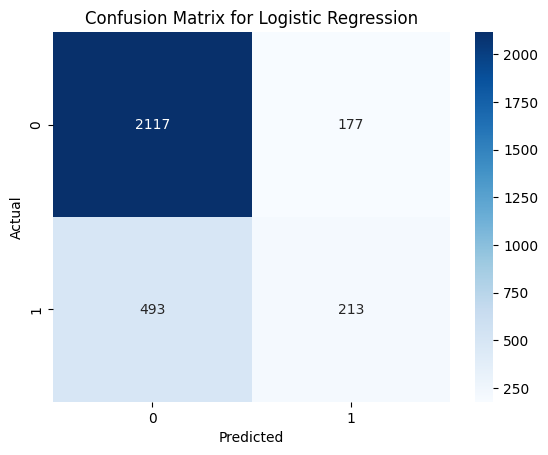

Decision Tree - Accuracy: 0.9750, ROC-AUC: 0.9714
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2294
           1       0.93      0.96      0.95       706

    accuracy                           0.97      3000
   macro avg       0.96      0.97      0.97      3000
weighted avg       0.98      0.97      0.98      3000



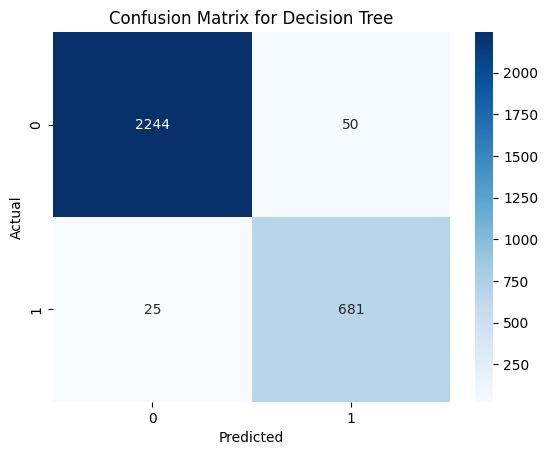

Random Forest - Accuracy: 0.9880, ROC-AUC: 0.9789
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2294
           1       0.99      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



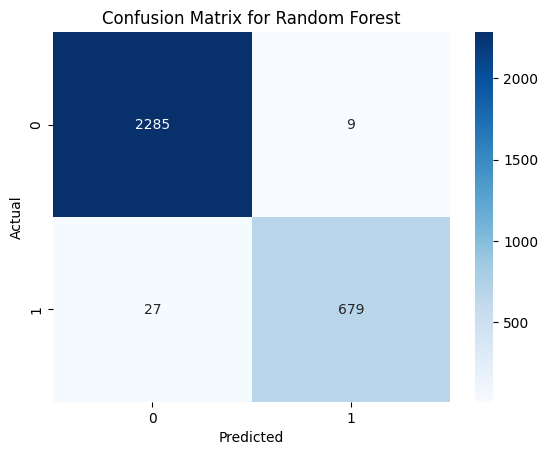

Gradient Boosting - Accuracy: 0.9737, ROC-AUC: 0.9563
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2294
           1       0.96      0.92      0.94       706

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



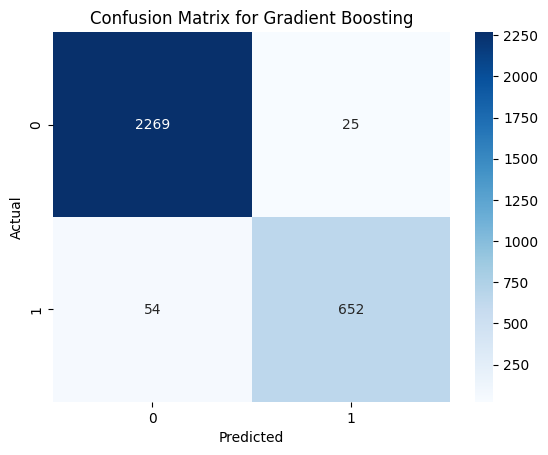

                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.776667  0.612271
1        Decision Tree  0.975000  0.971397
2        Random Forest  0.988000  0.978917
3    Gradient Boosting  0.973667  0.956307


In [0]:
# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append((model_name, accuracy, roc_auc))
    print(f'{model_name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}')
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC-AUC'])
print(results_df)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/05/19 22:33:10 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.12.2/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Random Forest - Grid Search - Accuracy: 0.9837, ROC-AUC: 0.9692
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2294
           1       0.99      0.94      0.96       706

    accuracy                           0.98      3000
   macro avg       0.99      0.97      0.98      3000
weighted avg       0.98      0.98      0.98      3000



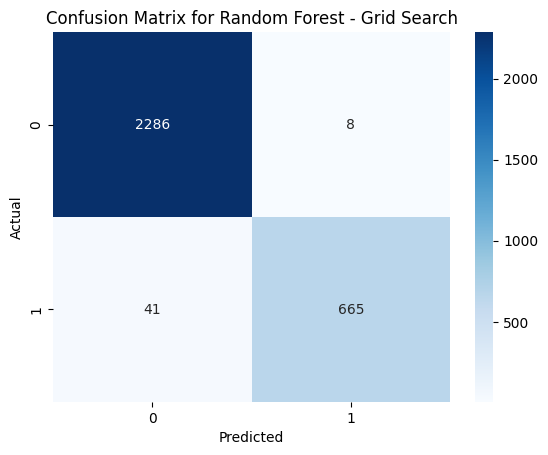

In [0]:
from sklearn.model_selection import GridSearchCV
import mlflow

# Define parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# Perform grid search with MLflow logging
with mlflow.start_run(run_name="Random Forest - Grid Search"):
    grid_search.fit(X_train_scaled, y_train)
    
    best_rf_model = grid_search.best_estimator_
    y_pred = best_rf_model.predict(X_test_scaled)
    accuracy = best_rf_model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Log parameters, metrics, and best model
    mlflow.log_param("model_name", "Random Forest - Grid Search")
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(best_rf_model, "Random Forest - Grid Search")
    
    print(f'Random Forest - Grid Search - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}')
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Random Forest - Grid Search')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
